Обучить генератор создавать точки, которые будут лежать на графике функции:  
    $$y = \frac{sin(x)}{x} - \frac{x}{10} $$ 
    
При выполнении данного задания структура GAN остается той же, но Вам нужно:
1. Сгенерировать настоящие данные
2. Изменить архитектуру дискриминатора и генератора
3. Построить графики

In [1]:
import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt
from matplotlib import patches

import torch
from torch import nn, optim

from IPython import display

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
x = torch.linspace(-20, 20, steps=1000)
y = (torch.sin(x) / x) - (x / 10)

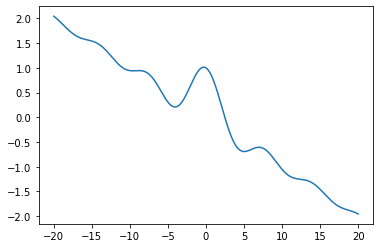

In [4]:
plt.plot(x, y)

In [5]:
data = pd.DataFrame({'x': x, 'y': y})
data

,x,y
0,-20.000000,2.045647
1,-19.959959,2.040880
2,-19.919920,2.036037
3,-19.879879,2.031120
4,-19.839840,2.026131
...,...,...
995,19.839840,-1.941837
996,19.879879,-1.944856
997,19.919920,-1.947947
998,19.959959,-1.951112


In [6]:
class NewDataset(torch.utils.data.Dataset):
    
    def __init__(self, data):
        self.x = np.atleast_2d(data[:, 0]).T
        self.y = np.atleast_2d(data[:, 1]).T
        self.data_len = data[:, 0].shape[0]
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        
        some_x = self.x[idx]
        some_y = self.y[idx]
        
        return some_x, some_y

In [7]:
dataset = NewDataset(data.values)

In [8]:
dl_data = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)

In [9]:
class Generator(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        
        self.model = nn.Sequential(
            nn.Linear(in_dim, 1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self, in_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 1),
            nn.Tanh(),
            nn.Linear(in_dim, 1),
            nn.LeakyReLU(0.2),
            nn.Linear(1, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [11]:
def sample_points(true_values, pred_values):
    
    x_true, y_true = true_values
    x_pred, y_pred = pred_values
    
    plt.plot(x, y)
    plt.scatter(x_true, y_true, label='True_values')
    plt.scatter(x_pred, y_pred, label='Pred_values')
    
    plt.legend()
    
    plt.show()

In [12]:
generator = Generator(1, 1)
generator.to(device)

discriminator = Discriminator(1)
discriminator.to(device)

optim_G = optim.Adam(generator.parameters())
optim_D = optim.Adam(discriminator.parameters())

adversarial_loss = torch.nn.BCELoss()

In [13]:
d_loss_history = []
g_loss_history = []

In [14]:
red_patch = patches.Patch(color='red', label='D loss')
green_patch = patches.Patch(color='green', label='G loss')

In [15]:
epochs = 30
batch_size = 8

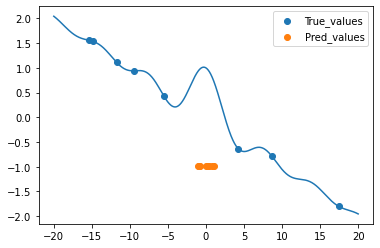

[Epoch 29/30] [Batch 75/125]|[D loss: 0.6917456388473511] [G loss: 0.6985604166984558]


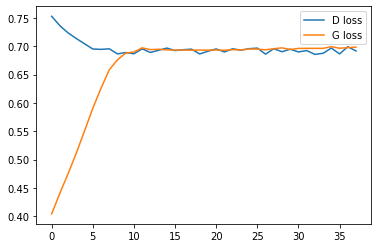

In [16]:
for epoch in range(epochs):
    for i, (x_i, y_i) in enumerate(dl_data):
        
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)
        
        real_y = y_i.type(torch.FloatTensor).to(device)
        
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, 1))).to(device)
        
        gen_y = generator(z)
        
        
        
        real_pred = discriminator(real_y)
        
        d_real_loss = adversarial_loss(real_pred, valid)
        
        fake_pred = discriminator(gen_y)
        
        d_fakel_loss = adversarial_loss(fake_pred, fake)
        
        d_loss = (d_real_loss + d_fakel_loss) / 2
        
        optim_D.zero_grad()
        d_loss.backward()
        optim_D.step()
        
        
        # генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, 1))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_y = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_y)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optim_G.zero_grad()
        g_loss.backward()
        optim_G.step()
        
        batches_done = epoch * len(dl_data) + i
    
        if batches_done % 100 == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                sample_points((x_i, y_i), (z, gen_y))
                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dl_data)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 


                # display.display(plt.gcf())
                plt.show()
                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.show()        
        